# SPDR ETF Composite Sector Valuation [Friday 4.10.2015]
=============================================================================================

### The following Ipython Notebook examines the Implied Cost of Capital (ICC) method of valuation for purposes of trade/portfolio positioning. The goal is to identify asymmetric investing opportunities due to incongruence between 'recent' historical valuations and forward looking expectations of earnings growth. 

### I will attempt to accomplish the goal by first examining composite returns based on ETF category groupings. Then I will compare the historical data vs the forward looking ICC estimate to see if we can find some disagreement. 

######**Please note there will be some overlap as some of the groupings include international sector ETF's while other groupings contain regional and/or country ETF's. 

### First set up the environment, lists and other necessary metadata

In [1]:
# ================================================================== #
# composite returns; vol; risk adjusted returns; correlation matrix, ICC analysis

from pprint import pprint as pp
import pandas as p
import numpy as np
import pandas.io.data as web
from pandas.tseries.offsets import *
import datetime as dt
import math
import seaborn as sns
sns.set_style('white')

import matplotlib.pyplot as plt

import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

import cufflinks 

# ================================================================== #

date_today = dt.date.today()
month = 'APR-2015'

# ~~~ Market Cap ~~~ #
Broad_mkts = ['THRK','RSCO'] # Russell 3000, Russell Small Cap Completeness
Large_cap  = ['ONEK','SPY','SPYG','SPYV'] # Russell 1000, sp500 (growth, value)
Mid_cap    = ['MDY','MDYG', 'MDYV'] # sp400 mid (growth, value)
Small_cap  = ['TWOK','SLY','SLYG','SLYV'] # russ 2K, sp600, (growth, value)

# ~~~ International/Global Equities ~~~ #
Global = [
        'DGT', #  global dow
        'BIK', # sp BRIC 40 ETF
        'GMM', # sp emerging mkts 
        'EWX', # sp emerging mkts small caps
        'CWI', # msci acwi ex-US
        'GII', # global infrastructure
        'GNR', # global natural resources
        'DWX', # intl dividends
        'GWL', # sp developed world ex-US 
        'MDD', # intl mid cap (2B-5B USD)
        'GWX'  # intl small cap (<2B USD)
        ]

Asia   = ['JPP','JSC','GXC','GMF'] # japan, smallcap japan, china, emg asiapac
Europe = ['FEZ','GUR','RBL','FEU'] # euro stoxx 50, emg europe, russia, stoxx europe 50
Latam  = ['GML'] # emg latin america
Africa = ['GAF'] # emg mideast/africa

# ~~~ Real Assets ~~~ #
Real_assets = [ 'RWO', # global real estate
                'RWX', # intl real estate ex-US
                'RWR'  # US select REIT
                ]        

# ~~~ sectors and industries ETF's ~~~ #
Sector = [
          'XLY','XHB','IPD','XRT',                   # consumer discretionary
          'XLP','IPS',                               # consumer staples
          'XLE','IPW','XES','XOP',                   # energy
          'XLF','KBE','KCE','KIE','IPF','KRE',       # financials
          'XLV','XBI','XHE','XHS','IRY','XPH',       # healthcare
          'XLI','XAR','IPN','XTN',                   # industrial
          'XLB','IRV','XME',                         # materials
          'XLK','MTK','IPK','XSD','XSW',             # technology
          'IST','XTL',                               # telecom
          'IPU','XLU'                                # utilities
          ]
   
stock_list = [Broad_mkts, Large_cap, Mid_cap, Small_cap, Global, Asia, Europe, Latam, Africa, Real_assets, Sector]

# ~~~ Category structure ~~~ #
cat = {'Broad_Market'          :['THRK','RSCO'],
       'Large_Cap'             :['ONEK','SPY','SPYG','SPYV'],
       'Mid_Cap'               :['MDY','MDYG', 'MDYV'], 
       'Small_Cap'             :['TWOK','SLY','SLYG','SLYV'],
       'Global_Equity'         :['DGT','BIK','GMM','EWX','CWI','GII','GNR','DWX','GWL','MDD','GWX'],
       'AsiaPac_Equity'        :['JPP','JSC','GXC','GMF'],
       'Europe_Equity'         :['FEZ','GUR','RBL','FEU'],
       'Latam_MidEast_Africa'  :['GML','GAF'],
       'Real_Estate'           :['RWO','RWX','RWR'],
       'Consumer_Discretionary':['XLY','XHB','IPD','XRT'],
       'Consumer_Staples'      :['XLP','IPS'],                         
       'Energy'                :['XLE','IPW','XES','XOP'],                   
       'Financials'            :['XLF','KBE','KCE','KIE','IPF','KRE'],
       'Healthcare'            :['XLV','XBI','XHE','XHS','IRY','XPH'],
       'Industrial'            :['XLI','XAR','IPN','XTN'],
       'Materials'             :['XLB','IRV','XME'],
       'Technology'            :['XLK','MTK','IPK','XSD','XSW'],
       'Telecom'               :['IST','XTL'],                            
       'Utilities'             :['IPU','XLU']
        }    

filepath   = r'C:\Users\Owner\Documents\Visual Studio 2013\Projects\iVC_Reporting_Engine\PythonApplication2\\'

### Now I define a convenience function to grab stock prices. 

In [2]:
# ================================================================== #
# get prices
def get_px(stock, start, end):
    '''
    Function to call Pandas' Yahoo Finance API to get daily stock prices.
    
    Parameters:
    ==========
    stock = type('str'); stock symbol 
    start = 3 business days before today; datetime date_today object offset by pandas.DateOffset method 
    end   = today; datetime date_today object

    Returns:
    ========
    time series = Pandas.Series object corresponding to stock symbol, and start/end dates
    **Note that if price column is not specified the function will return a Pandas.DataFrame object
    '''      
    try:
        return web.DataReader(stock, 'yahoo', start, end)['Adj Close']
    except Exception as e:
        print( 'something is fucking up' )

px = p.DataFrame()
for category in stock_list:
    for stock in category:
        px[stock] = get_px( stock, date_today - 252 * BDay(), date_today )

### Calculate the log returns for our ETF's then construct the dataframe with proper multi index for grouping

In [3]:
# ================================================================== #
# construct dataframe and proper multi index
log_rets = np.log( px / px.shift(1) ).dropna()

lrets = log_rets.T.copy()
lrets.index.name = 'ETF'
lrets['Category'] = p.Series()

for cat_key, etf_val in cat.items():
    for val in etf_val:
        if val in lrets.index:
            idx_loc = lrets.index.get_loc(val)
            lrets.ix[idx_loc,'Category'] = cat_key
        else:
            pass

lrets.set_index('Category', append=True, inplace=True)
lrets = lrets.swaplevel('ETF','Category').sortlevel('Category')
lrets.head()

Date                 2014-04-24  2014-04-25  2014-04-28  2014-04-29  \
Category       ETF                                                    
AsiaPac_Equity GMF    -0.000525   -0.008303    0.000000    0.008041   
               GXC    -0.003968   -0.007554   -0.017171    0.011432   
               JPP    -0.004619   -0.002928    0.003659    0.004131   
               JSC    -0.002766    0.003827    0.003601    0.003588   
Broad_Market   RSCO   -0.003065   -0.009898   -0.009084    0.006238   

Date                 2014-04-30  2014-05-01  2014-05-02  2014-05-05  \
Category       ETF                                                    
AsiaPac_Equity GMF    -0.003815    0.004602   -0.000262   -0.003417   
               GXC    -0.008380    0.003621    0.005479   -0.006925   
               JPP    -0.003887    0.011135   -0.000241   -0.000964   
               JSC    -0.009102    0.019582   -0.007745   -0.002314   
Broad_Market   RSCO   -0.000259    0.006201    0.002444   -0.000900   

Date                 2014-05-06  2014-05-07     ...      2015-03-27  \
Category       ETF                              ...                   
AsiaPac_Equity GMF     0.001710   -0.003819     ...        0.004293   
               GXC    -0.002319   -0.010650     ...        0.014915   
               JPP    -0.004832   -0.006317     ...       -0.004558   
               JSC    -0.005703   -0.004245     ...       -0.001719   
Broad_Market   RSCO    0.000000   -0.009171     ...        0.005435   

Date                 2015-03-30  2015-03-31  2015-04-01  2015-04-02  \
Category       ETF                                                    
AsiaPac_Equity GMF     0.023118   -0.004195    0.008710    0.012201   
               GXC     0.033764   -0.007064    0.015824    0.013055   
               JPP     0.008271   -0.005162   -0.003941    0.000623   
               JSC     0.003815    0.000000   -0.013225    0.012654   
Broad_Market   RSCO    0.017038   -0.009569   -0.004244    0.011430   

Date                 2015-04-06  2015-04-07  2015-04-08  2015-04-09  \
Category       ETF                                                    
AsiaPac_Equity GMF     0.008751   -0.000883    0.025933    0.019703   
               GXC     0.010505    0.000454    0.063665    0.036915   
               JPP     0.017499    0.002853   -0.004283    0.001021   
               JSC     0.018498    0.000000    0.001495   -0.003742   
Broad_Market   RSCO    0.000454    0.000795   -0.001136    0.000568   

Date                 2015-04-10  
Category       ETF               
AsiaPac_Equity GMF    -0.004016  
               GXC    -0.009905  
               JPP    -0.001430  
               JSC     0.005048  
Broad_Market   RSCO    0.007806  

[5 rows x 243 columns]

### Calculate the cumulative returns of each ETF

In [4]:
# ================================================================== #
# cumulative returns of ETF's
cum_rets = lrets.groupby(level='Category').cumsum(axis=1)
cum_rets.head()

Date                 2014-04-24  2014-04-25  2014-04-28  2014-04-29  \
Category       ETF                                                    
AsiaPac_Equity GMF    -0.000525   -0.008828   -0.008828   -0.000787   
               GXC    -0.003968   -0.011521   -0.028692   -0.017260   
               JPP    -0.004619   -0.007547   -0.003888    0.000243   
               JSC    -0.002766    0.001062    0.004663    0.008251   
Broad_Market   RSCO   -0.003065   -0.012963   -0.022047   -0.015809   

Date                 2014-04-30    2014-05-01  2014-05-02  2014-05-05  \
Category       ETF                                                      
AsiaPac_Equity GMF    -0.004602  4.943962e-17   -0.000262   -0.003680   
               GXC    -0.025641 -2.201976e-02   -0.016541   -0.023467   
               JPP    -0.003645  7.490672e-03    0.007250    0.006286   
               JSC    -0.000850  1.873147e-02    0.010987    0.008673   
Broad_Market   RSCO   -0.016068 -9.867447e-03   -0.007424   -0.008323   

Date                 2014-05-06  2014-05-07     ...      2015-03-27  \
Category       ETF                              ...                   
AsiaPac_Equity GMF    -0.001970   -0.005789     ...        0.124885   
               GXC    -0.025786   -0.036436     ...        0.153120   
               JPP     0.001454   -0.004863     ...        0.155363   
               JSC     0.002970   -0.001276     ...        0.105743   
Broad_Market   RSCO   -0.008323   -0.017495     ...        0.100490   

Date                 2015-03-30  2015-03-31  2015-04-01  2015-04-02  \
Category       ETF                                                    
AsiaPac_Equity GMF     0.148004    0.143809    0.152519    0.164720   
               GXC     0.186884    0.179820    0.195644    0.208699   
               JPP     0.163634    0.158472    0.154532    0.155155   
               JSC     0.109558    0.109558    0.096333    0.108987   
Broad_Market   RSCO    0.117528    0.107959    0.103714    0.115144   

Date                 2015-04-06  2015-04-07  2015-04-08  2015-04-09  \
Category       ETF                                                    
AsiaPac_Equity GMF     0.173471    0.172589    0.198522    0.218225   
               GXC     0.219204    0.219658    0.283324    0.320239   
               JPP     0.172654    0.175507    0.171225    0.172246   
               JSC     0.127485    0.127485    0.128980    0.125238   
Broad_Market   RSCO    0.115599    0.116394    0.115258    0.115826   

Date                 2015-04-10  
Category       ETF               
AsiaPac_Equity GMF     0.214210  
               GXC     0.310334  
               JPP     0.170816  
               JSC     0.130286  
Broad_Market   RSCO    0.123632  

[5 rows x 243 columns]

### Calculate a composite cumulative return based on the ETF categories. Each ETF is given equal weighting within its own category. I plot the result.

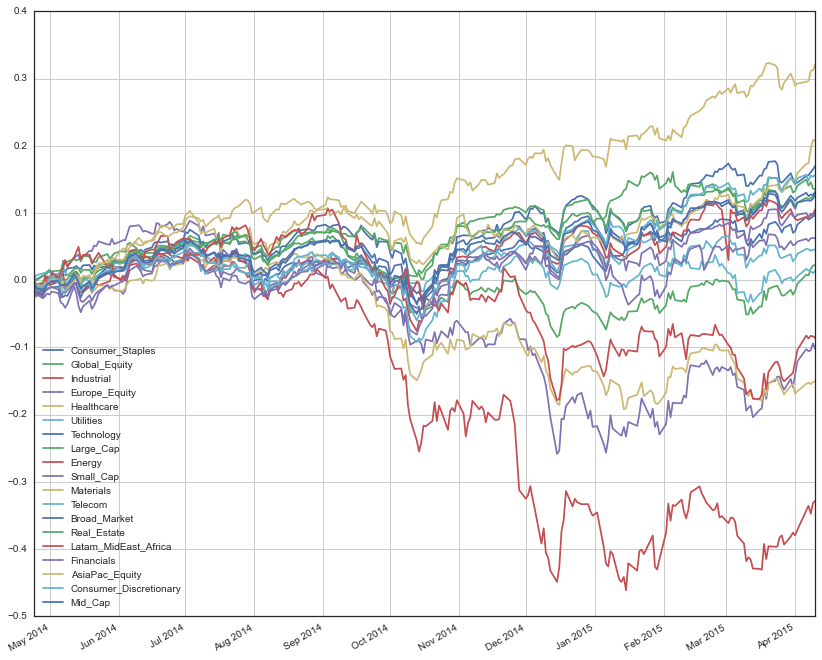

In [5]:
# ================================================================== #
# composite groupings of cumulative ETF returns (equally weighted intra-category mean returns)
composite_rets = p.DataFrame()
for label in cat.keys():
    composite_rets[label] = cum_rets.ix[label].mean(axis=0) # equal weighted mean
    
comp_rets = np.round(composite_rets.copy(),4) # rounding

# to demonstrate the enhanced interactivity of Ploty charts first plot matplotlib
%matplotlib inline

size=(14,12)
composite_rets.plot(figsize=size)
plt.show()

### The basic plot is ok but how much can you really interpret from the previous time series given that there are 19 different categories? Probably not much. Good thing I have a solution. 

### I use a combination of `Plotly's API` and the `Cufflinks` module to create interactive charts. Plotly's charts allow for: zoom, pan, zoom-in, zoom-out, autoscale in addition to the awesome interactive data display. 

### Below I create a convenince function to construct the layout I want to pass to the `df.iplot` method. 

In [6]:
# ~~~~~ plot code ~~~~~ 
# function to create Plotly 'Layout' object

def create_layout( main_title, y_title ):
    '''
    Function to create custom Plotly layout object to pass to Cufflinks df.iplot() method
    
    Parameters:
    ==========
    
    main_title = type('str')
    y_title    = type('str')

    Returns:
    ========
    plotly_layout = Plotly Layout object basically constructed using a JSON or Dict structure    
    '''    
    plotly_layout = Layout(
        # ~~~~ construct X axis
        xaxis=XAxis(
            title='Date',
            titlefont=Font(
                family='oxygen, sans-serif',
                size=18,
                color='grey'
            ),
            showticklabels=True,
            tickangle=-30,
            tickfont=Font(
                family='oxygen, sans-serif',
                size=11,
                color='black'
            ),
            exponentformat='e',
            showexponent='All'
        ),
        # ~~~~ construct Y axis
        yaxis=YAxis(
            title= y_title,
            titlefont=Font(
                family='oxygen, sans-serif',
                size=18,
                color='grey'
            ),
            showticklabels=True,
            tickangle=0,
            tickfont=Font(
                family='oxygen, sans-serif',
                size=11,
                color='black'
            ),
            exponentformat='e',
            showexponent='All'),
        # ~~~~ construct figure size
            autosize=False,
            title= main_title,
            width=1000,
            height=500,
            margin=Margin(
            l=60,
            r=30,
            b=70,
            t=30,
            pad=5
        )
    )
    return plotly_layout

### See the resulting plot below

In [7]:
# test the function
title = 'Cumulative Log Returns of Composite ETF Sectors [1 Year]'
y_label = 'Return'

custom_layout_1 = create_layout( title, y_label )
comp_rets.iplot(theme='white',filename='Tutorial White', layout=custom_layout_1, world_readable=True)

### Calculate the ETF category standard deviation of returns. Then construct a moving average of the composite sigmas and plot the data

In [8]:
# ================================================================== #
# composite rolling std

sigmas = lrets.groupby(level='Category').std() # equal weighted std

composite_sigs = p.DataFrame()
for label in cat.keys():
    composite_sigs[label] = sigmas.ix[label] 

rsigs = p.rolling_mean( composite_sigs, window=60 ).dropna()*math.sqrt(60)

# ~~~~~ plot code
title = '60 day Moving Average of Standard Deviation'
y_label = '$\sigma$'

custom_layout_2 = create_layout( title, y_label )
rsigs.iplot(theme='white',filename='Tutorial White', layout=custom_layout_2, world_readable=True)

### Now I calculate a risk adjusted return metric. For simplicity I assume there is no benchmark ETF return. I use the formula: 

## $R_{risk} = \mu/\sigma$

### I plot the result below

In [9]:
# ================================================================== #
# composite rolling risk adjusted returns

mean_rets = lrets.groupby(level='Category').mean() # equal weighted mean
#risk_rets = (mean_rets-lrets.loc['Global_Equity','DGT'])/sigmas
#risk_rets = mean_rets/sigmas

composite_risk_rets = p.DataFrame()
for label in cat.keys():
    composite_risk_rets[label] = mean_rets.ix[label] 

rs = p.rolling_mean( composite_risk_rets, window=60 ).dropna() 
risk_rets = rs/rsigs

# ~~~~~ plot code
title = r'60 day Moving Average of Composite Risk-Adjusted Returns'
y_label = 'Risk-Adjusted Return'

custom_layout_3 = create_layout( title, y_label )
risk_rets.iplot(theme='white', filename='Tutorial White', layout=custom_layout_3, world_readable=True)

### For portfolio positioning/rebalancing we need to see the correlations of the return data. To do that I construct a composite correlation matrix and plot the results. 

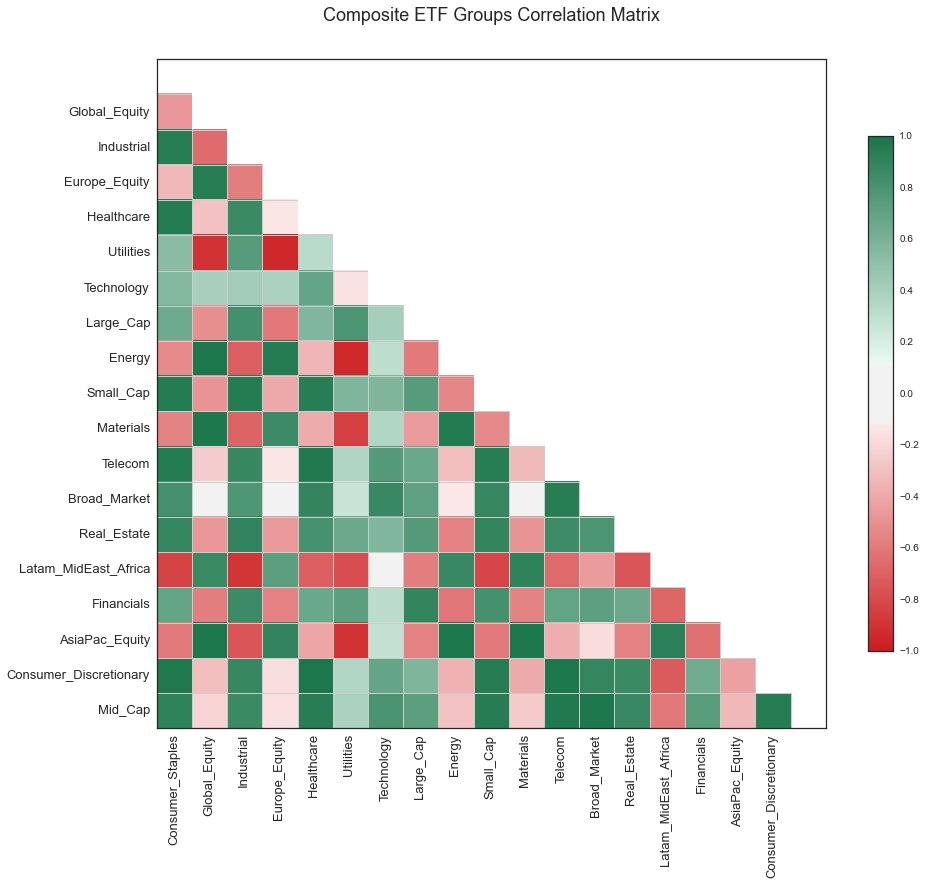

In [10]:
# ================================================================== #
# correlation matrix of composite ETF groups' risk adjusted returns

cor = risk_rets.corr()

# ~~ plot code
f, ax = plt.subplots(figsize=(14, 12))

cmap = sns.diverging_palette(h_neg=12, h_pos=144, s=91, l=44, sep=29, n=12, center='light',as_cmap=True)
sns.corrplot(cor, annot=False, sig_stars=False, diag_names=False, cmap=cmap, ax=ax)
ax.set_title('Composite ETF Groups Correlation Matrix', fontsize=18)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(13)

f.tight_layout()

### Now that we have our historical return analysis I need to import my `ICC` estimates. 
------------------
### A quick review of the `ICC` model for the uninitiated:

### The `ICC` model is really an `internal rate of return (IRR) ` metric that uses the `Residual Income Model` of valuation. I present the basic formula below:

## ${Price}_{0} = {BVPS}_{0} +$ $\sum\limits_{t=1}^{T}$ $\frac {RI_{t}}{(1 + r)^t} +$ $\frac {{Terminal} {Value}}{(1 + r)^t}$
### where: 
#### $RI_{t} =$ ${EPS}_{t} - $$({r} * {BVPS}_{t-1})$
#### ${Terminal}$ ${Value} =$ ${EPS}_{t} * (1 + g) / (r - g)$
#### $g =$ $estimated$ $long$ $term$ $growth$ $rate$
#### $r = $$cost$ $of$ $equity$

### By solving for `r` aka the `cost of equity` we can estimate a market implied cost of equity or `ICC` for our purposes. This methodology allows us to solve for the market expected rate of growth over the estimated period that equates the future value of the stock to today's prices. The beauty of the metric is that it uses analysts' consensus `EPS` forecast to "solve backwards" to today's prices giving us a view into institutional investors' market expectations. 

### Before some smart ass chimes in to say equity analysts' estimates are "bullshit" or consistently "wrong" I would respond you're missing the point. My goal in calculating this metric is to take a snapshot of current market expectations (psychology) of the future. Analyst accuracy is largely irrelevant. 

### The simple reason being that the market trades on expectations of future events. If you can understand what your opponents' expectations are you have an advantage. 

### A simple example: If the calculation reveals the market expectations for future earnings growth of a sector like `Utilities (XLU)` is relatively low compared to its historical stock performance, an astute investor would interpret the signal as `"the sector is ripe for correction and likely to surprise to the downside"`. This could be because earnings estimates are declining or the stock price has already "priced in" future growth. The point being that it would be unwise to be a buyer at these hypothetical levels as the data hints at a likely "top" in value barring any opposing identifiable catalyst. 

In [11]:
# ================================================================== #
# import ICC estimates
frame = p.read_csv( filepath+'Spdr_ICC_est_{}.csv'.format(date_today) , index_col=0 ).dropna()
# ================================================================== #
# group ICC data by category
f        = frame.copy()
grp      = f.groupby('Category')
grp_mean = grp.mean().sort('ETF_ICC_est', ascending=False)

In [12]:
grp_mean = np.round( grp_mean['ETF_ICC_est'], 4 )
grp_mean

Category
Financials                0.2390
Europe_Equity             0.2234
AsiaPac_Equity            0.2066
Energy                    0.1989
Utilities                 0.1886
Global_Equity             0.1853
Materials                 0.1807
Latam_MidEast_Africa      0.1774
Industrial                0.1405
Telecom                   0.1396
Small_Cap                 0.1369
Large_Cap                 0.1349
Mid_Cap                   0.1334
Consumer_Discretionary    0.1305
Broad_Market              0.1300
Real_Estate               0.1253
Technology                0.1238
Consumer_Staples          0.1125
Healthcare                0.1084
Name: ETF_ICC_est, dtype: float64

### I'm a fan of z_scoring data like this so I can get a better sense of the extreme values 

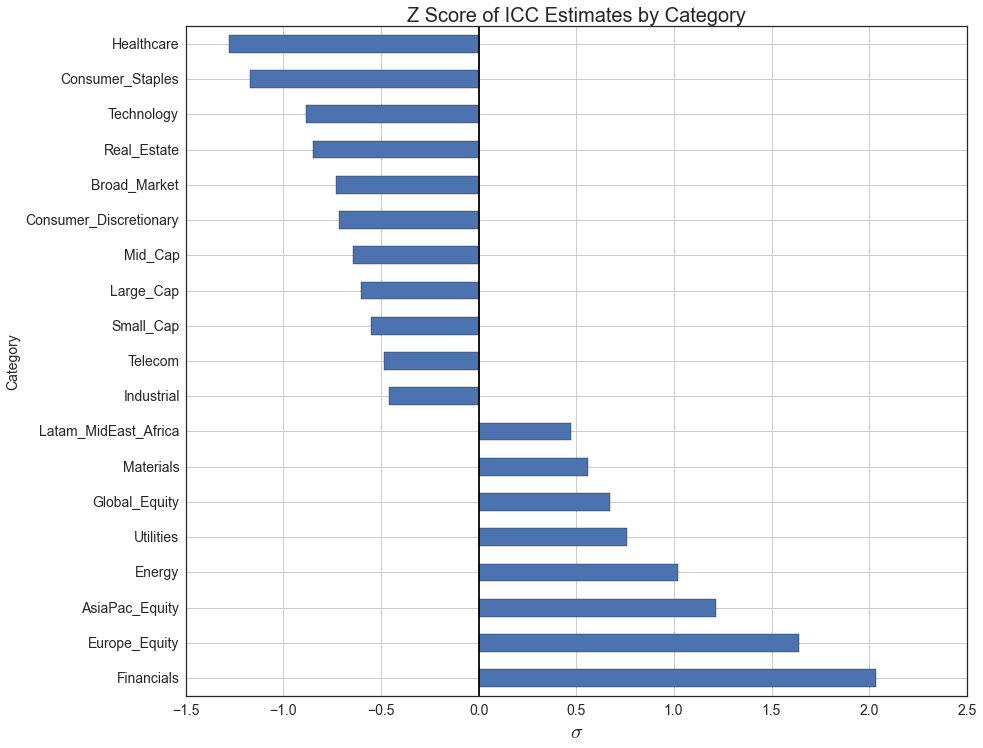

In [13]:
def z_score(df):
    return ( df - df.mean() ) / df.std()

#z_grp = (grp_mean - grp_mean.mean()) / grp_mean.std()
z_grp = z_score(grp_mean)

plt.figure(figsize=size);
z_grp.plot('barh')
plt.axvline(0, color='k')
plt.title('Z Score of ICC Estimates by Category', fontsize=20)
plt.xlabel('$\sigma$', fontsize=20)
plt.ylabel('Category', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)


### For comparative purposes I use the an average of the last 30 day's risk adjusted returns by ETF category. I then z score the data and plot it

In [14]:
# last 30 days average category risk adjusted returns
date_mask = date_today - 30 * BDay()
l_30 = risk_rets.ix[date_mask:].mean().order(ascending=False) 
l_30

Mid_Cap                   0.057472
Small_Cap                 0.044519
Healthcare                0.032464
Broad_Market              0.031701
AsiaPac_Equity            0.029141
Consumer_Discretionary    0.029017
Technology                0.022732
Real_Estate               0.021424
Large_Cap                 0.019745
Consumer_Staples          0.019637
Telecom                   0.014653
Global_Equity             0.012840
Industrial                0.009095
Europe_Equity             0.007231
Financials                0.005599
Energy                   -0.002108
Materials                -0.003659
Latam_MidEast_Africa     -0.006793
Utilities                -0.015113
dtype: float64

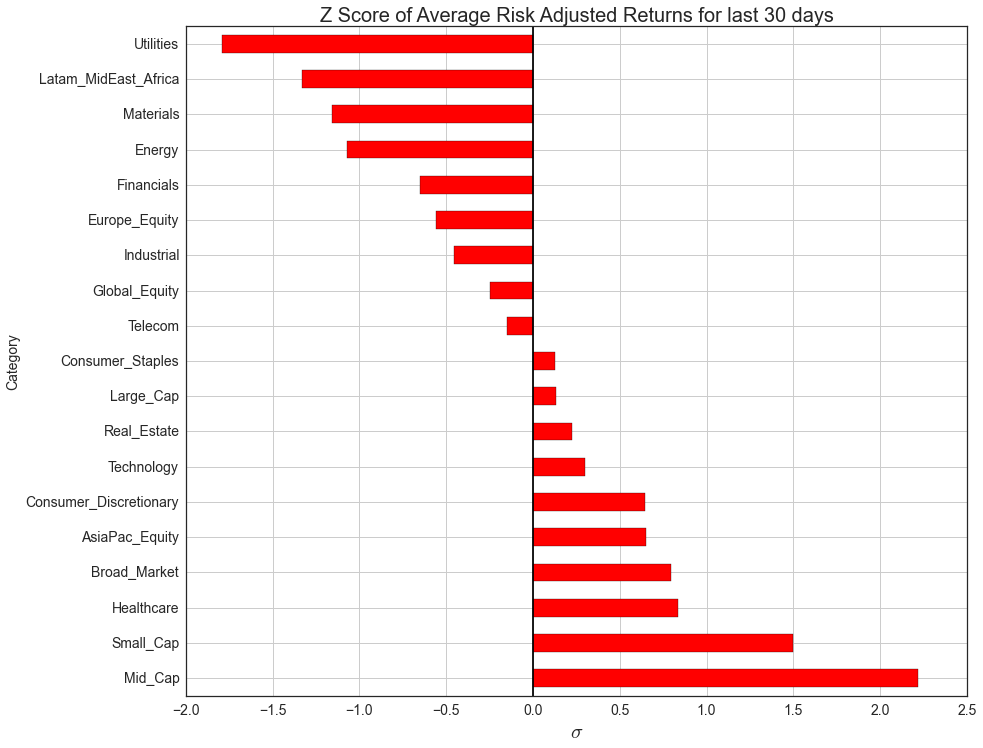

In [15]:
# z scored and plotted
z_l_30 = z_score(l_30)

plt.figure(figsize=size);
z_l_30.plot('barh',color='r')
plt.axvline(0, color='k')
plt.title('Z Score of Average Risk Adjusted Returns for last 30 days', fontsize=20)
plt.xlabel('$\sigma$', fontsize=20)
plt.ylabel('Category', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)

### Finally I construct a dataframe comprised of both series of z scored data and plot them for comparison purposes. Again we are looking for 'significant' discrepencies between historical return data and market implied EPS growth expectations. Let's plot the results.

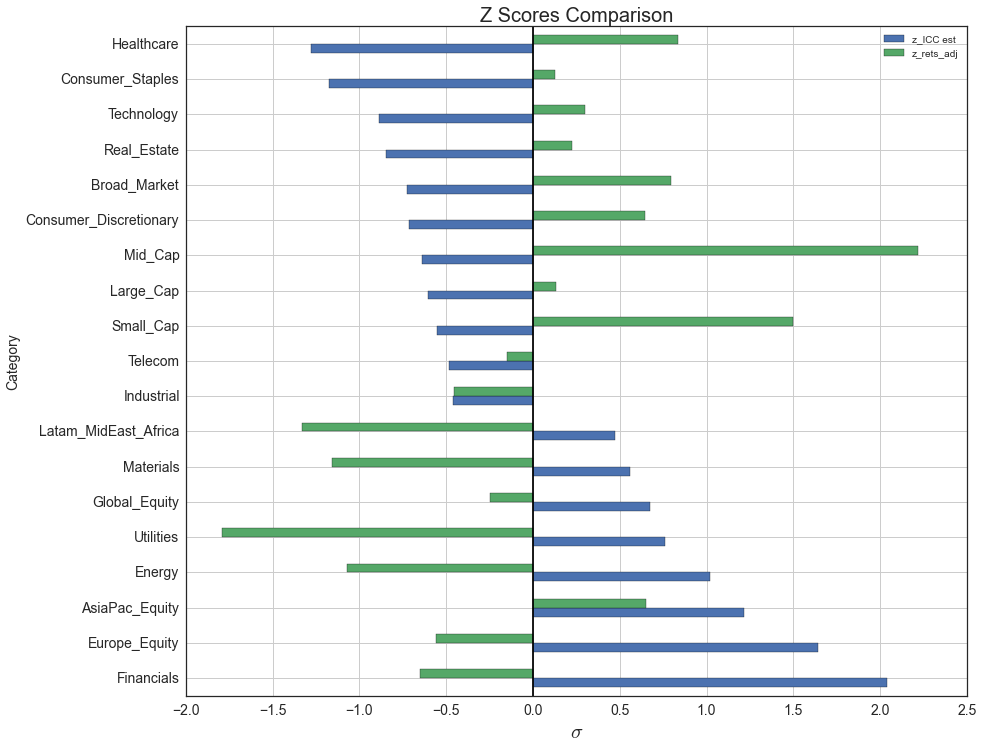

In [16]:
z_data = p.DataFrame()
z_data['z_ICC est'] = z_grp
z_data['z_rets_adj'] = z_l_30
# z_data.head()

plt.figure()
z_data.plot(kind='barh',figsize=size)
plt.axvline(0, color='k')
plt.title('Z Scores Comparison', fontsize=20)
plt.xlabel('$\sigma$', fontsize=20)
plt.ylabel('Category', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)

### There are some interesting results here. 

### Potential Long Positions:
================================
### - Europe_Equity is intriguing. Already off to a relatively strong start on the year, they are actively devaluing the `EURO` and effectively using the `ECB` as put on the bond market. If the `ECB` can replicate what the `Fed` did for U.S. risk assets European equity markets could be setting up for a long term bull run. At the very least we government tailwinds behind any long position. 
### - Financials. Comparatively they have the highest implied growth rate moving forward. Generally I'm not a fan of the sector due to the complexity and diversity of the firms within it but broadly speaking, financials have room to run if the market believes the `Fed` will ever raises rates. It is assumed a rise in rates would improve the net interest margin for domestic banking institutions.

### Potential Short Positions:
================================
### - Mid Caps look ripe for correction if i may quote my previous example. Market implied growth is in the bottom half of z scored data but a look at the risk adjusted returns relative to the other sectors shows massive outperformance. To me that would indicate an overbought situation with asymmetric risk to the downside. At the very least the mid cap grouping warrants more investigation for overvalued ETF's and individual stocks. If price action confirms my bear bias I would look to get short. 

-------

### I conclude this analysis with the disclaimer that these calculations are presented `"as is"` and the data was aggregated from several sources. I recommend doing your own due diligence before taking any investment action and to stay within your personal risk/return objectives. 

### I will be making refinements as necessary as I personally use this methodology to get a macro valuation perspective. 

### For comments, questions, and feedback contact me at `bcr@blackarbs.com`